In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

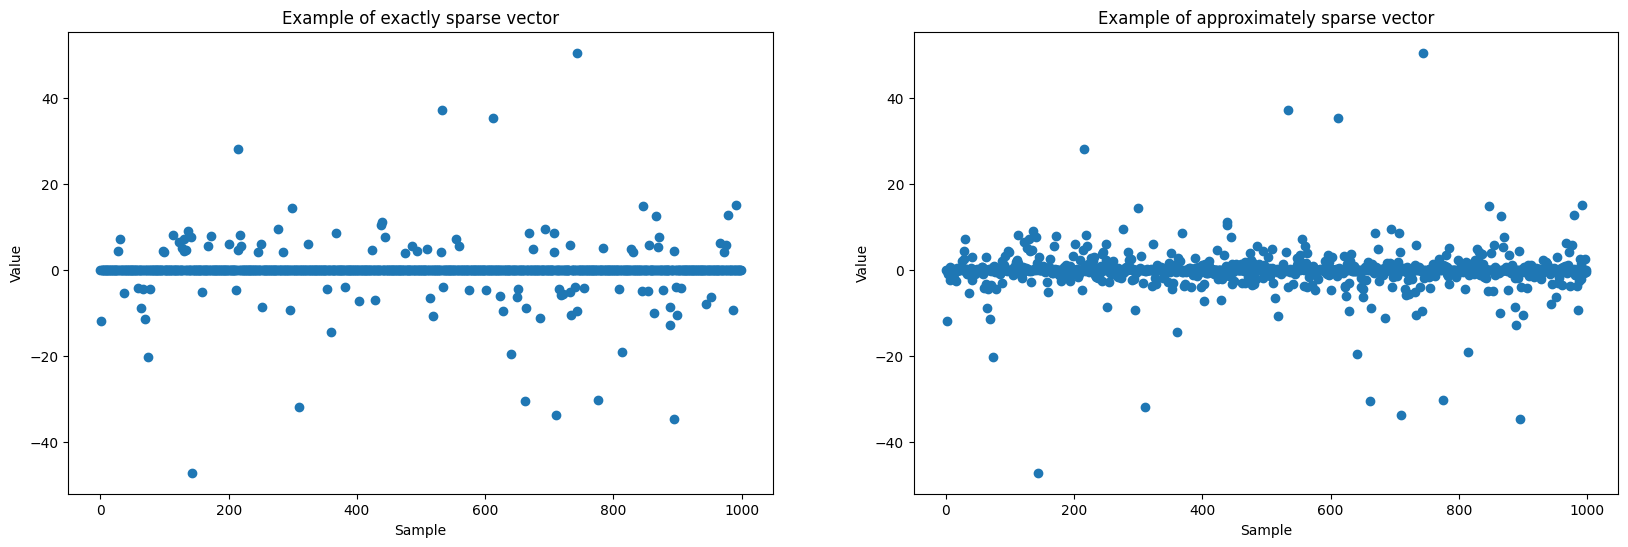

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

---
__Answer__:

Exact sparsity: A signal is said to be k-sparse if only "k" of its "t" elements *are* non-zero (k<<t).

Approximate sparsity: A signal is said to be approximately k-sparse if only "k" of its "t"  elements are *significantly different* from zero.

---

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

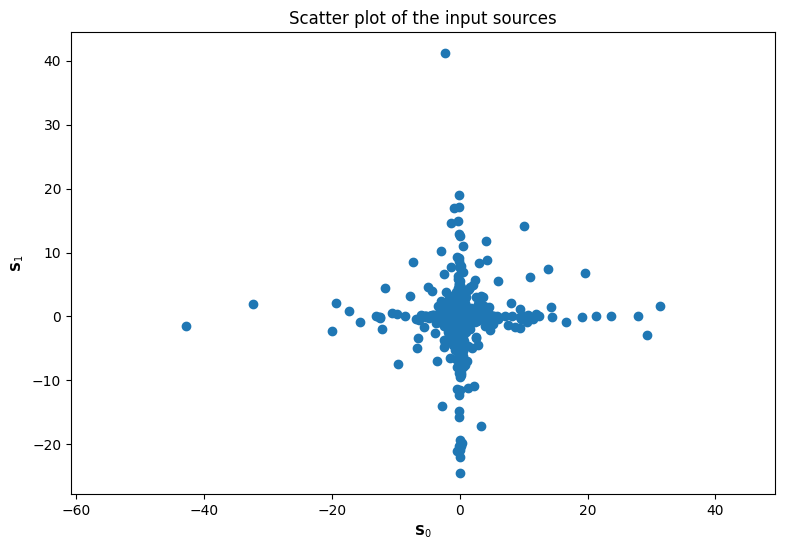

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation


# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
# You can use the np.random.randn function to generate Gaussian random variables.
S = np.random.randn(n,t)**power


fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ? 

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

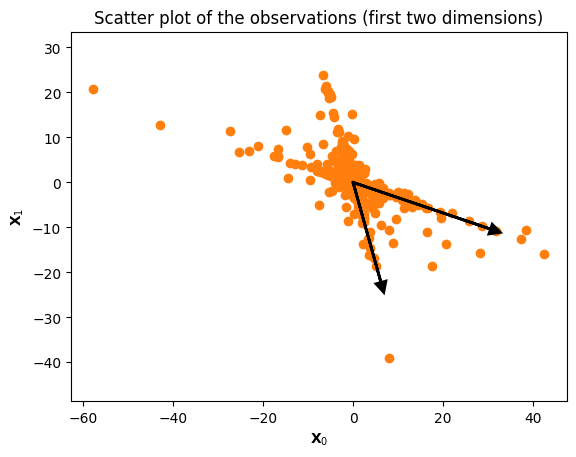

In [5]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

__ANSWER__: Geometrically, sparse sources can be identified in the previous plot as data close to a four-pointed star centered at zero. After multiplying the sources by the mixing matrix one can identify that the data is modified by rotation and scaling. Recovering the sources amounts to back-project the observations on the canonical axes.

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

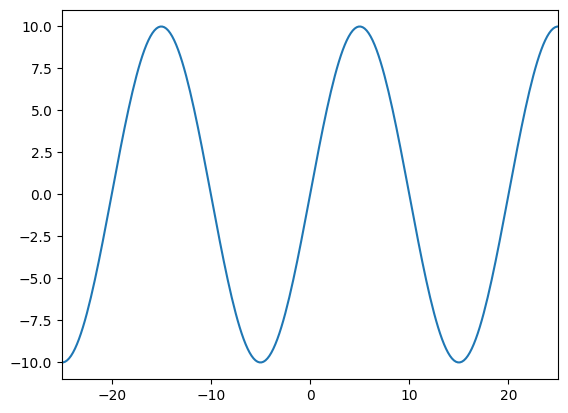

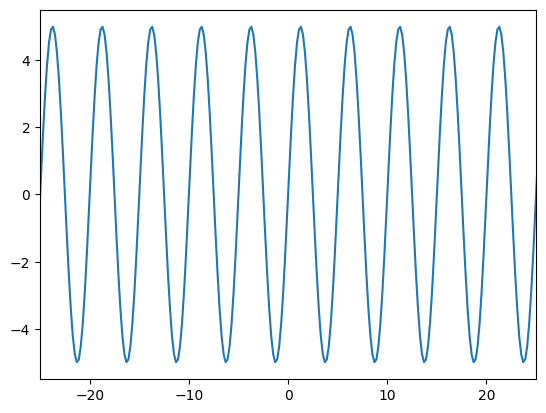

In [6]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

# signals
S = np.zeros((2,t))
f0 = 0.05 
f1 = 0.2   
S[0,:] = 10*np.sin(2*np.pi*f0*x_abs)
S[1,:] = 5*np.sin(2*np.pi*f1*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

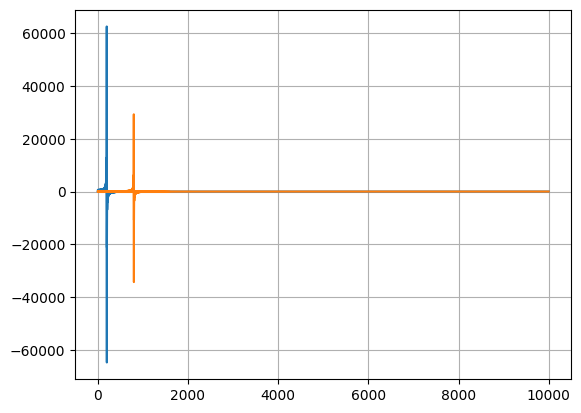

In [7]:
# Transformation into the DCT domain
Sf = sff.dct(S)

plt.figure()
plt.plot(Sf[0,:])
plt.plot(Sf[1,:])
plt.grid()

__ANSWER__: We want to find a sparse representation of the sources in a transformed domain. The DCT is a good candidate for this purpose since applying it which signal with a different frequency will have a different peak in the DCT domain. This is what we observe in the plot. After we can differentiate and separate the sources by looking at the peaks in the DCT domain.

Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

We can see that the noise is not sparse in DCT. We can also see that the sources are superimposed in the DCT domain. 

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

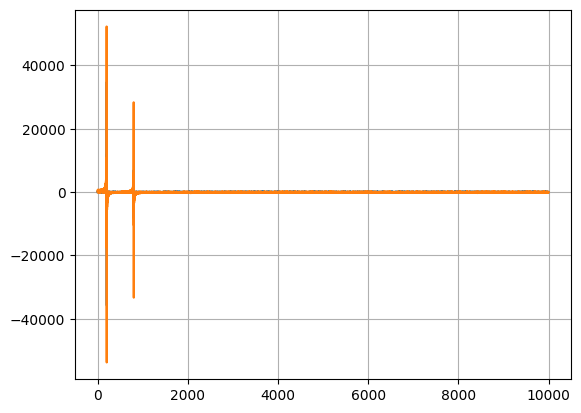

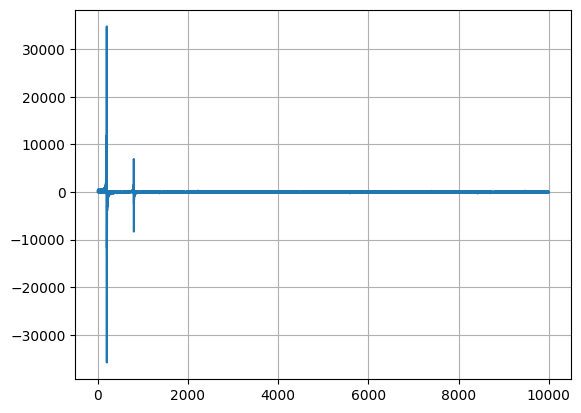

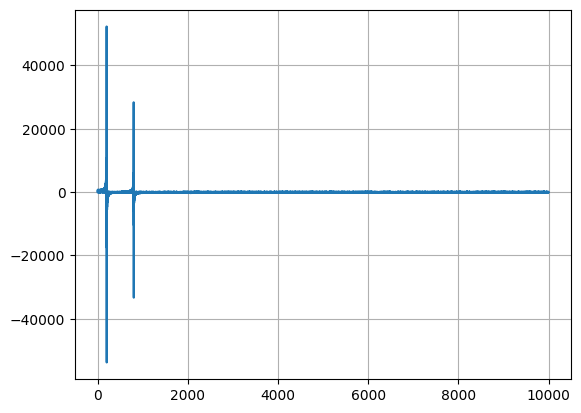

In [8]:
A = np.array([[0.5547002 , 0.24253563],
              [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

Xf = sff.dct(X)

#plotting the two signals in the same figure
plt.figure()
plt.plot(Xf[0,:])
plt.plot(Xf[1,:])
plt.grid()
#plotting the two signals in two different figures
plt.figure()
plt.plot(Xf[0,:])
plt.grid()
plt.figure()
plt.plot(Xf[1,:])
plt.grid()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

__ANSWER__: 

$\argmin_{A \in \R^{m \times n}, S \in \R^{n \times t}} \frac{1}{2}||X-AS||^2_F + \lambda ||S||_1$ 

The cost function is convex but not smooth due to the $||S||_1$. 

The first term $\frac{1}{2}||X-AS||^2_F$ is the data fidelity term and the second term $\lambda ||S||_1$ is the sparsity constraint. 

Compute the gradient along the S variable of the data-fidelity term.

$\nabla_S (\frac{1}{2}||X-AS||^2_F) = A^T(AS-X)$

Recall what the proximal operator of the l1-norm is.

proximal operator is the soft-thresholding operator: 

$prox_{\lambda ||.||_1}(x) = sign(x) \odot max(|x|-\lambda,0) = \begin{cases} x-\lambda & \text{if } x > \lambda \\ 0 & \text{if } -\lambda \leq x \leq \lambda \\ x+\lambda & \text{if } x < -\lambda \end{cases}$  

![soft-thresholding](soft2.png)


In [9]:
# TO DO: implement the proximal operator of the l1-norm
# in the above function:
# The proximal operator of the l1-norm 
# is the soft-thresholding operator

def prox_l1(S_est,thrd):
    S_est = np.sign(S_est)*np.maximum(np.abs(S_est)-thrd,0)
    return S_est

Explain the main idea of the ISTA algorithm. Then, implement it.

The ISTA algorithm main idea is to iteratively update an estimate of the sparse signal by applying a soft thresholding operation to the current estimate combined with a gradient step. The algorithm aims to find the sparsest solution that fits the given measurements or observations.

In [10]:
# TO DO: implement the ISTA algorithm 
# to minimize the cost function you wrote in question II-2-1.
# 
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((n,np.shape(X)[1]))
    S_est_old = np.zeros((n,np.shape(X)[1]))
    for i in range(nbIt):
        S_est = prox_l1(S_est_old + A.T@(X-A@S_est_old), lamb)
        S_est_old = S_est
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

__ANSWER__: The minimum value we should not go below is 0 since it'll make the optimization problem try to maximize the non-sparse signal. The issue with choosing too big values is that the algorithm will set the signal to zero.

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

__ANSWER__: The sources are sparse in the DCT domain. The DCT is a rotation and a scaling of the canonical axes. The sources are sparse in the canonical axes.

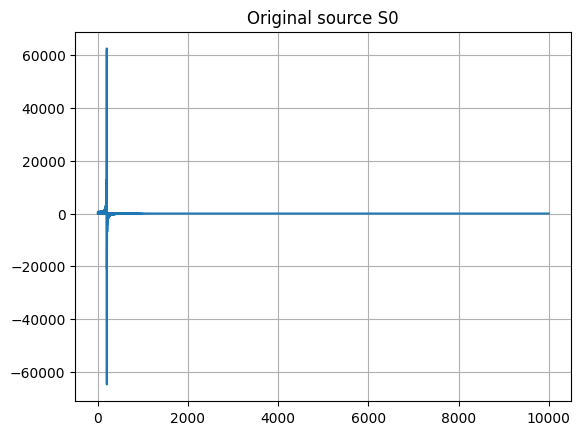

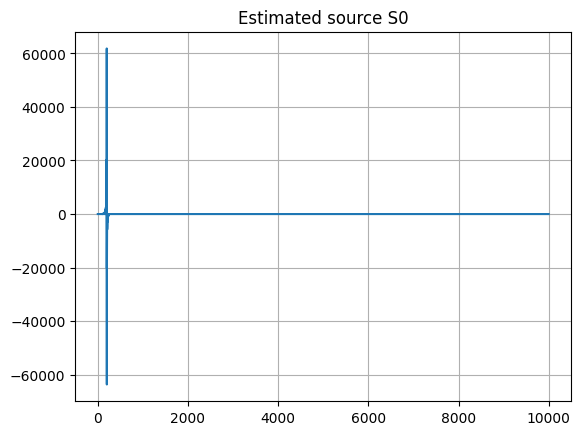

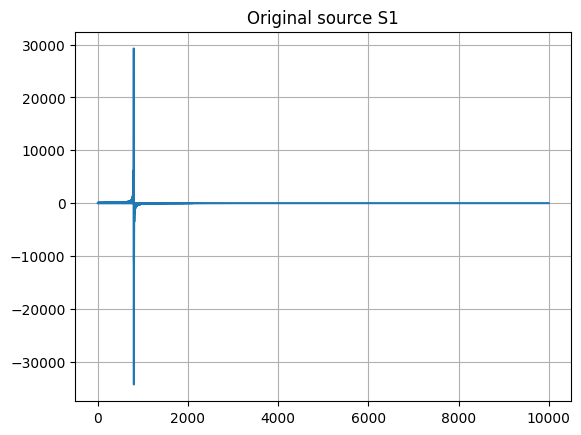

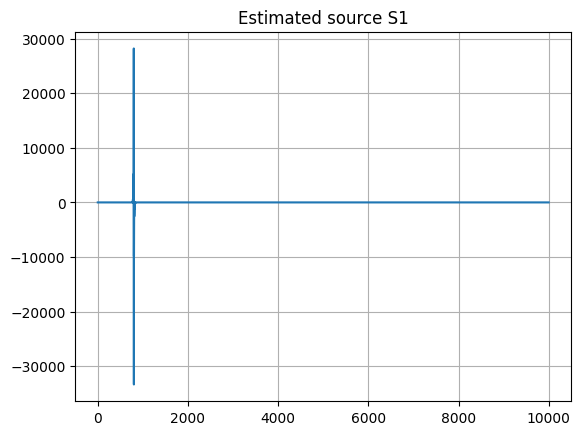

In [11]:
S_estf = ISTA(Xf,A = A,n=2, lamb=1000,nbIt = 1000)
plt.figure()
plt.title('Original source S0')
plt.plot(Sf[0,:])
plt.grid()
plt.figure()
plt.title('Estimated source S0')
plt.plot(S_estf[0,:])
plt.grid()
plt.figure()
plt.title('Original source S1')
plt.plot(Sf[1,:])
plt.grid()
plt.figure()
plt.title('Estimated source S1')
plt.plot(S_estf[1,:])
plt.grid()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

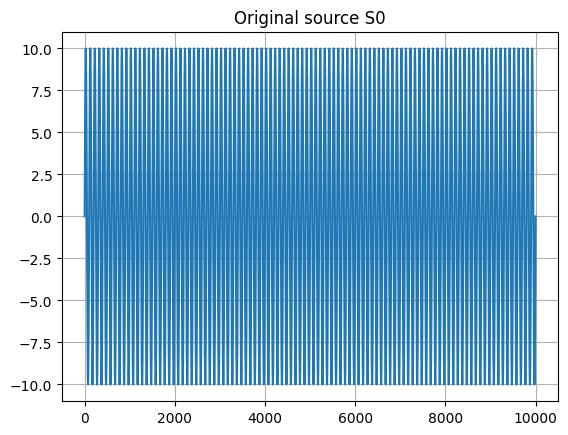

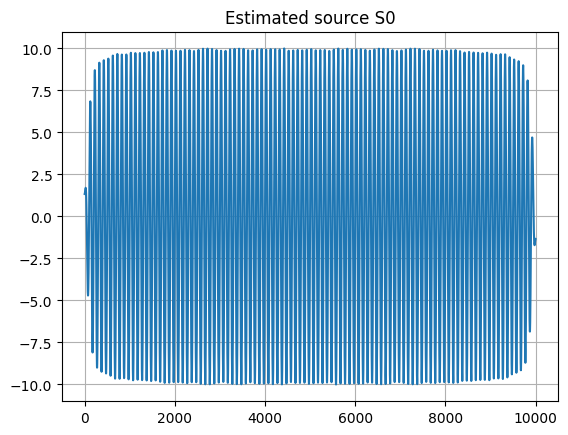

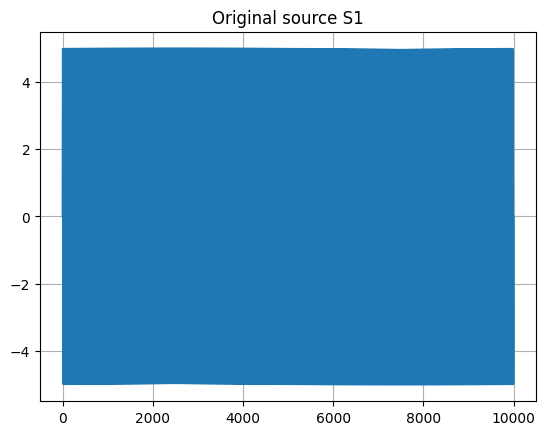

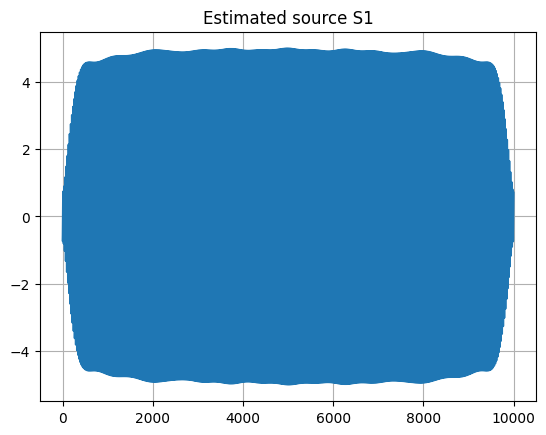

In [12]:
# transforming the estimated sources back to the original domain
S_est = sff.idct(S_estf)
S_est = S_est/np.max(np.abs(S_est),axis=1)[:,None]
S_est = S_est*np.max(np.abs(S),axis=1)[:,None]

#plotting the estimated sources
plt.figure()
plt.title('Original source S0')
plt.plot(S[0,:])
plt.grid()
plt.figure()
plt.title('Estimated source S0')
plt.plot(S_est[0,:])
plt.grid()
plt.figure()
plt.title('Original source S1')
plt.plot(S[1,:])
plt.grid()
plt.figure()
plt.title('Estimated source S1')
plt.plot(S_est[1,:])
plt.grid()


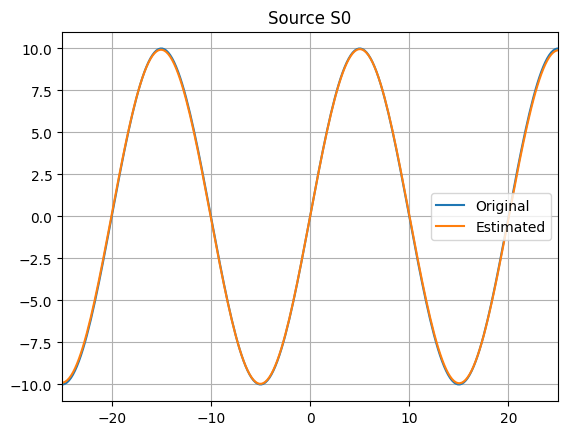

In [14]:
plt.figure()
plt.title('Source S0')
plt.plot(x_abs, S[0,:], label = 'Original')
plt.plot(x_abs, S_est[0,:], label = 'Estimated')
plt.xlim([-25,25])
plt.legend()
plt.grid()

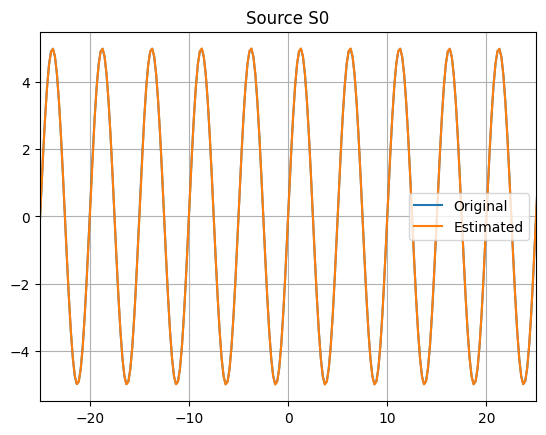

In [15]:
plt.figure()
plt.title('Source S0')
plt.plot(x_abs, S[1,:], label = 'Original')
plt.plot(x_abs, S_est[1,:], label = 'Estimated')
plt.xlim([-25,25])
plt.legend()
plt.grid()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




$\argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}} \frac{1}{2}||X-AS||^2_F + \lambda||S||_1+ \iota_{\{\forall i \in [1,n]; ||a_{:,j}||^2_{l_2} \le1\}}(A) $

As before: 

the first term: $\frac{1}{2}||X-AS||^2_F$  is the data-fidelity term

the second term: $\lambda||S||_1$  is the sparsity constraint on the sources. 

The third term (newer term): $\iota_{\{\forall i \in [1,n]; ||a_{:,j}||^2_{l_2} \le1\}}(A)$ is the constraint on the columns of the mixing matrix. With this constraint we are ensuring that the columns of the mixing matrix are normalized. 



Recall what the gradient of the data fidelity term over A is.

__ANSWER__: The gradient of the data fidelity term over A is 

$$\nabla_A (\frac{1}{2}||X-AS||^2_F) = (AS-X)S^T$$

Compte the proximal operator of the oblique constraint. Implement it.

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [33]:
def prox_oblique(A):
    A = A/np.maximum(np.linalg.norm(A,axis=0), 1)
    return A

def PALM(X,n=2,lamb=0,nbIt = 100):
    # Initialization
    A_est = np.eye(n)
    S_est = np.zeros((n,np.shape(X)[1]))
    for i in range(nbIt):
        # Update of S
        dA = A_est.T @ (X - A_est @ S_est)
        denA = np.linalg.norm(A_est.T @ A_est)+1e-16
        S_est = prox_l1(S_est + 0.9/denA * dA, lamb)
        # Update of A
        dS = (X - A_est @ S_est) @ S_est.T
        denS = np.linalg.norm(S_est @ S_est.T)+1e-16
        A_est = prox_oblique(A_est + 0.9/denS * dS)
    return A_est,S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

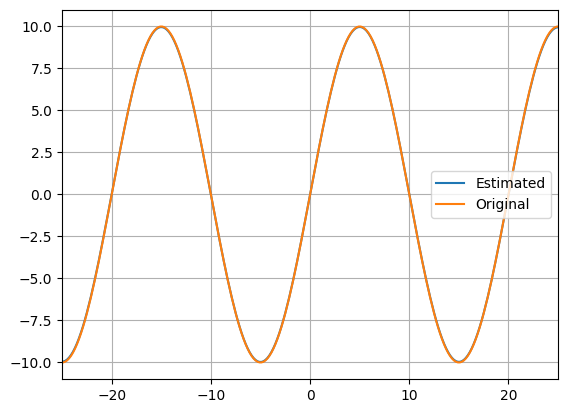

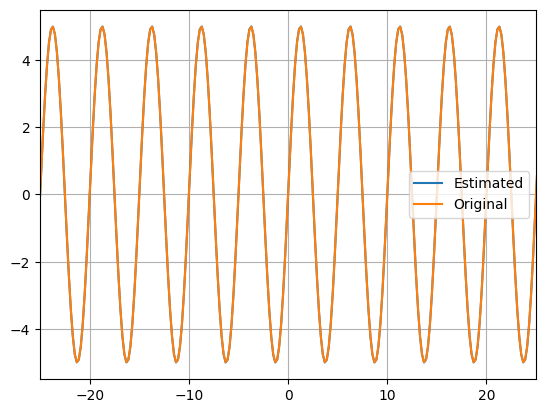

In [36]:
A_fest, S_fest = PALM(Xf, n=2, lamb=1000, nbIt=1000)

S_fest = sff.idct(S_fest)
S_fest = S_fest/np.max(np.abs(S_fest),axis=1)[:,None]
S_fest = S_fest*np.max(np.abs(S),axis=1)[:,None]

plt.figure()
plt.plot(x_abs, S_fest[0], label = 'Estimated')
plt.plot(x_abs,S[0,:], label = 'Original')
plt.xlim([-25,25])
plt.legend()
plt.grid()

plt.figure()
plt.plot(x_abs, S_fest[1], label = 'Estimated')
plt.plot(x_abs,S[1,:], label = 'Original')
plt.xlim([-25,25])
plt.legend()
plt.grid()

